# RegTech Session: KYC and sanctions

This session present an example focusing on sanctions development and their place in modern regulation industry. We cover the following topis:

* KYC, and KYC intersection with sanction lists (in presentation)
* Landscape of sanctions: individual vs. sectorial
* Relevant databases of sanctioned entities: OFAC, etc.
* Example 1: Sanctions on entities 
    * Building identity matching software
    * Decision of the intervention threshold
    * Limitations and Challenges
* Example 2: Sectoral and secondary sanctions
    * ...




In [ ]:
#!pip install fuzzywuzzy
#!pip install Levenshtein 
#!pip install seaborn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
import urllib3

#from sklearn.cluster import KMeans
#from sklearn.decomposition import PCA
from datetime import datetime, timedelta

from scipy.stats import zscore
from transaction_laboratory import transactionLaboratory
from schemes import random_behavior, layering, round_tripping, sanctionAvoidance
from fuzzywuzzy import fuzz

## Example 1: KYC and sanction lists

### Aim and description of our exersize

In this example, we download data of sactioned entities (persons, companies, organizations) and implement a simple matching function that provides string similarity scores calculated by various methods.

### Relevant sources of saction lists

* [Office of Foreign Assets Control (OFAC)](https://sanctionssearch.ofac.treas.gov/Details.aspx?id=13087)
* [EU sanction map](https://www.sanctionsmap.eu)
* [UK sanction list](https://www.gov.uk/government/publications/the-uk-sanctions-list)
* private sources, e.g., [www.opensanctions.org](https://www.opensanctions.org/)

Let us use one of these sources to download a list of sanctioned entities.

[See names.txt of this link](https://www.opensanctions.org/datasets/default/)

In [ ]:
target_url = 'https://data.opensanctions.org/datasets/20250130/default/names.txt?v=20250130065302-gpf'

http = urllib3.PoolManager()
response = http.request('GET', target_url)
lines = response.data.decode('utf-8')
lines = lines.split('\n')

### Identity matching software

In [ ]:
def check_name(name, risk_treshold = 85):
  suspected_entities = []

  if name in lines:
    return [(name, 100, 'is in the list')]
  else:
    levenstein_ratio = partial_ratio = token_sort_ratio = 0.0
    for line in lines:

      levenstein_ratio = fuzz.ratio(name, line)
      if levenstein_ratio > risk_treshold:
        suspected_entities.append((line,levenstein_ratio,'lev-ratio'))

      token_sort_ratio = fuzz.token_sort_ratio(name, line, full_process=False)
      if token_sort_ratio > risk_treshold:
        suspected_entities.append((line,token_sort_ratio,'tok-ratio'))

    return suspected_entities

In [23]:
#here, enter name of your fauvorite terrorist
check_name('Kim Jong Un')

[('Jong Man Kim', 87, 'tok-ratio'),
 ('Kim Jong Man', 87, 'lev-ratio'),
 ('Kim Jong Man', 87, 'tok-ratio'),
 ('Kim Jong Eun', 87, 'lev-ratio'),
 ('Kim Džong Un', 87, 'lev-ratio'),
 ('Kim Džong Un', 87, 'tok-ratio'),
 ('Kim Dzong Un', 87, 'lev-ratio'),
 ('Kim Dzong Un', 87, 'tok-ratio'),
 ('Kim Yong Un', 91, 'lev-ratio'),
 ('Jong Un Kim', 100, 'tok-ratio'),
 ('Kim Jong Gun', 87, 'lev-ratio'),
 ('Kim Un Jon', 95, 'tok-ratio'),
 ('Kim Un Jong', 100, 'tok-ratio'),
 ('Kim Jung Un', 91, 'lev-ratio'),
 ('Kim Jung Un', 91, 'tok-ratio'),
 ('Un Jong Kim', 100, 'tok-ratio'),
 ('Un Gyong Kim', 87, 'tok-ratio')]

In [24]:
#here, enter name of someone who is probably not a terrorist
check_name('Peter Fratric')

[]

### Setting the decision threshold

In [25]:
#decrease the risk threshold, and see you get more matches
check_name('Peter Fratric', risk_treshold = 75)

[('Peter Frick', 83, 'lev-ratio'),
 ('Peter Frick', 83, 'tok-ratio'),
 ('Peter Frølich', 77, 'lev-ratio'),
 ('Peter Frølich', 77, 'tok-ratio'),
 ('Frantisek Peter', 79, 'tok-ratio'),
 ('František Peter', 79, 'tok-ratio'),
 ('Peter Friedrich', 79, 'lev-ratio'),
 ('Peter Friedrich', 79, 'tok-ratio'),
 ('Friedrich, Peter', 76, 'tok-ratio'),
 ('Peter Frolich', 77, 'lev-ratio'),
 ('Peter Frolich', 77, 'tok-ratio'),
 ('Peter Forster', 77, 'lev-ratio'),
 ('Peter Forster', 77, 'tok-ratio'),
 ('Peter Ferraro', 77, 'lev-ratio'),
 ('Peter Ferraro', 77, 'tok-ratio'),
 ('Peter Francis', 77, 'lev-ratio'),
 ('Peter Francis', 77, 'tok-ratio'),
 ('Peter Ferrara', 77, 'lev-ratio'),
 ('Peter Ferrara', 77, 'tok-ratio'),
 ('Peter Fitzpatrick', 80, 'lev-ratio'),
 ('Peter Fitzpatrick', 80, 'tok-ratio'),
 ('Fitzpatrick, Peter', 77, 'tok-ratio'),
 ('Peter Gration', 77, 'lev-ratio'),
 ('Peter Gration', 77, 'tok-ratio')]

Question to think about: How would you set the intervention treshold? What data would you use? Explain steps to be taken.

### Limitations and challanges

Let us think about following questions:
 * What sort of data can we get to improve our entity matching?
 * Are there some issues with frequency of updates?
 * Can sanctioned entities benefit still get their hands on assets by obscuring their involvement?

### Things can get more complex

Certain individuals can have complex links to various companies or off-shore trusts. For example, consider:

In [29]:
check_name('KERIMOVA, Gulnara Suleymanovna')

[('KERIMOVA, Gulnara Suleymanovna', 100, 'is in the list')]

Miss Kerimova is associated with several companies such as:

- VH ANTIBES SAS
- VILLA LEXA ESTATES SAS
- SERVICE IMMOBILIERE ANTIBES SAS
- SERVICE IMMOBILIERE ET GESTION SAS


and is a relative of Suleiman Kerimov.
see: https://www.opensanctions.org/entities/NK-L2UmsZtsyvYiaEmHSaiZ2t/


Mr. Kerimov himself is an owner of Nafta Moscow, is a member of Russian government, and is active in off-shoring https://offshoreleaks.icij.org/nodes/82005744

## Example 2: Sectoral and secondary sanctions

One of the main issues of sanction lists is that the number of entities can be continuously increasing, and it is not always possible to identify who controls a company (links can be kept private or be present under thread of violence). Sectorial and secondary sanctions are the answer.

- **Sectoral sanctions**: In some countries companies are (or can be) entirely controlled by the government. This means any dual-use goods imported can be seized and used for military purposes. Moreover, exports from the sanctioned country of certain products can be beneficial for the world, or we simply might not want to punish groups of people who do not have any direct influence. 

References: See https://ofac.treasury.gov/sanctions-programs-and-country-information/ukraine-russia-related-sanctions

- **Secondary sanctions**: A non-sanctioned, so-called intermediate or shell, entity can be created to import dual-use goods in a 3rd country and pass it to the sanctioned country. Under secondary sanctions, you may still end up persecuted. Hence, one needs to do due diligence on supply chains and customers of your customers.


Questions to address:

1. How to determine if a company is high/low risk?
2. How to spot if a company suddenly changed their import/export behavior?


### Risk-based approach

In principle, it is not possible to identify if a customer poses a secondary sectoral risk for you, but you can estimate the risk based on well-established practices. If your risk estimation methods are sound, then you can avoid a fine (plausible deniability being plausible).

> How to determine the risk?

Let $x$ denote the goods, then risk is 

$$ Risk(x) = Probability("x \ will \ be \ passed \ to \ a \ sanctioned \ entity") \times PotentialFine(x) $$

$PotentialFine(x)$ depends on the jurisdictions and the type of goods. See a list of items prohibited for exports, e.g., [UK](https://www.gov.uk/government/publications/russia-sanctions-common-high-priority-items-list/15bbaf12-a67d-40ec-94b4-a6d5499c892b) or [EU](https://eur-lex.europa.eu/legal-content/EN/TXT/PDF/?uri=OJ:L:2022:049:FULL&from=EN). The fines can be a lot, e.g., \$1 million per violation or 50\% of transacted value. (See the potential fine only as a denomination. Clearly, irresponsibly exporting dual-use goods is immoral regardless if you get caught or not.)

> How to estimate the probability?

This can depend on the exact area. In general, one can adopt a scoring approach, that is, to express the probability as:

$$P(x) = \frac{1}{Z} \sum_{i} w_i r_i(x|D_i) $$

where $r_i(x|D_i)$ is the risk score based on $D_i$ (one particular "piece of data/knowledge"), $w_i$ is a weight such that $\sum_{i} w_i = 1$, and $Z$ is the normalization constant.



### Example 2.1. Exports to intermediate countries

We have seen that certain countries maintained close ties with Russia, serving as intermediaries facilitating sanction avoidance, e.g., see posts by [\@robin_j_brooks](https://x.com/robin_j_brooks).

Let us include consider potentially sanctioned categories of goods and construct our risk estimate $r_1$ based on data from the (2015-) World trade organization, see data on [this link](https://stats.wto.org/dashboard/tradeconnectivity_en.html) 



In [80]:
#we load trade data
exports = pd.read_csv(os.getcwd() + '\\data\\tradeconnectivity\\dataRus.csv')

#Select only export to russia (code C643 in selected_economy.csv) ---this was done beforehand to keep the file size low
#exports = exports.loc[exports['Reporter'] == 'C643']

#replace product codes with names
products = pd.read_csv(os.getcwd() + '\\data\\tradeconnectivity\\products.csv')
products = dict(zip(products['L3'].to_list(), products['L3Desc'].to_list()))
exports['L3'] = exports['L3'].map(products)

#select only categories of products that might be sanctioned (can be extended or made more specialized)
bucket = ['Inorganic chemicals', 'Rubber and rubber products', 'Measuring instruments', 'Optical and photographic products', 'Telecommunication equipement',
                      'Arms and ammunition', 'Aircraft', 'Motor vehicles', 'Bicycles and motorcycles', 'Electronic components']

exports = exports.loc[exports['L3'].isin(bucket)]

#and select countries with positive exports to russia
exports = exports.loc[exports['Ind4'] > 0.0]

#replace country codes with country names
countries = pd.read_csv(os.getcwd() + '\\data\\tradeconnectivity\\selected_economy.csv')
countries = dict(zip(countries['Reporter'].to_list(), countries['ReporterName'].to_list()))
exports['Reporter'] = exports['Reporter'].map(countries)
exports['Partner'] = exports['Partner'].map(countries)

exports.head(10)

,Unnamed: 0,L3,Reporter,Partner,Reporter_Total_Imports,Partner_Total_Imports,Reporter_Total_Exports,Partner_Total_Exports,Ind1,Ind2,Ind3,Ind4
60,7719,Telecommunication equipement,Russian Federation,Afghanistan,1.227274e+10,8.549799e+07,8.013958e+08,6.940077e+05,0.0000,0.0000,0.0000,0.0001
61,7846,Electronic components,Russian Federation,Afghanistan,1.928199e+09,8.993286e+07,1.825530e+08,3.689600e+05,0.0000,0.0000,0.0000,0.0008
184,23771,Inorganic chemicals,Russian Federation,Algeria,3.070079e+09,2.198339e+08,5.164535e+09,7.945959e+08,0.0002,0.0013,0.0307,0.0008
212,27327,Telecommunication equipement,Russian Federation,Algeria,1.227274e+10,1.421131e+09,8.013958e+08,6.065563e+06,0.0000,0.2118,0.1195,0.0116
213,27454,Electronic components,Russian Federation,Algeria,1.928199e+09,1.180932e+08,1.825530e+08,2.552670e+05,0.0000,0.0000,0.0000,0.0445
218,28089,Motor vehicles,Russian Federation,Algeria,1.727839e+10,3.276531e+09,2.515331e+09,1.300754e+07,0.0000,0.0364,0.0279,0.0046
222,28597,Optical and photographic products,Russian Federation,Algeria,7.004218e+08,4.283929e+07,2.772193e+08,2.200920e+05,0.0000,0.0000,0.0000,0.0645
223,28724,Measuring instruments,Russian Federation,Algeria,2.733093e+09,3.812042e+08,5.481837e+08,3.030022e+06,0.0000,0.0021,0.0031,0.0080
412,53259,Inorganic chemicals,Russian Federation,Azerbaijan,3.070079e+09,1.266362e+08,5.164535e+09,2.998850e+06,0.0003,0.0025,0.1028,0.3407
418,54021,Rubber and rubber products,Russian Federation,Azerbaijan,3.615534e+09,1.494443e+08,3.680441e+09,3.515970e+05,0.0000,0.0047,0.1148,0.0011


Having prepared our data, let's define risk as:

$$ r_1(x) = \frac{imports \ of \ sensitive \ goods \ x \in bucket}{|bucket|} $$ 

Let us calculate this value for 4 countries

In [81]:
test_countries = ['France', 'Armenia', 'China', 'Germany', 'Iran']

for country in test_countries:
    exports_from = exports.loc[exports['Partner'] == country]['Ind4']
    if len(exports_from) > 0:
        risk = sum(exports_from)/len(exports_from)
    else:
        risk = "no exports found in selected bucket"
    print(country + ':', "r_1 = ", risk)

France: r_1 =  0.008025000000000001
Armenia: r_1 =  0.3851428571428572
China: r_1 =  0.015525
Germany: r_1 =  0.0101
Iran: r_1 =  no exports found in selected bucket


#### Sanity check

Based on data from 2015 onwards, the estimate correctly predicts countries that comply with sanctions (France, Germany), China that complies with sanctions in a less limited scope, and Armenia that respects sanctions the least. The estimate is clearly incorrect about Iran. Why is that??

### Example 2.2: Change of import behavior

Imagine yourself as a compliance officer in a company that supplies micro-chips to a company 'Yangjie-Tech' based outside the EU. 

In [30]:
time_switch = datetime(2022, 4, 1, 8, 0, 0) 
rb = sanctionAvoidance(time_switch, amount1 = 100, amount2 = 115)
rb.start = datetime(2017, 2, 1, 8, 0, 0) 
df_rb = rb.generate(8*12)

df_rb.head(5)

,source,target,amount_per_month,product,time
0,chip-supplier,Yangjie-Tech,103.0,chip,2017-02-01 08:00:00
1,chip-supplier,Yangjie-Tech,106.0,chip,2017-03-01 08:00:00
2,chip-supplier,Yangjie-Tech,93.0,chip,2017-04-01 08:00:00
3,chip-supplier,Yangjie-Tech,96.0,chip,2017-05-01 08:00:00
4,chip-supplier,Yangjie-Tech,92.0,chip,2017-06-01 08:00:00


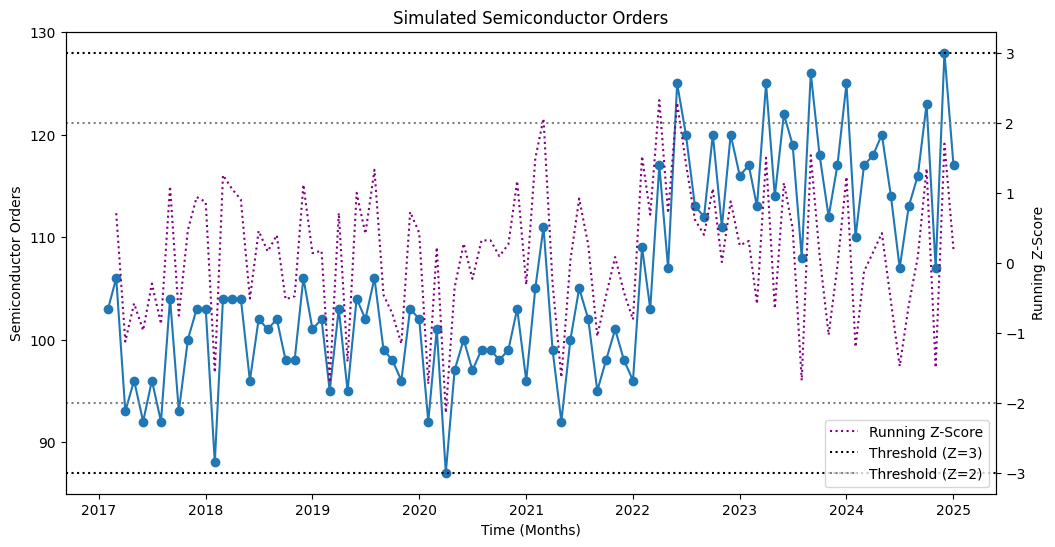

In [31]:
time = df_rb['time']
amounts = df_rb['amount_per_month']
# Compute running Z-score with a fixed window size
zscore = rb.running_zscore(amounts, window_size = 12)

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(time,  amounts, label='Orders per month', marker='o')
ax1.set_xlabel('Time (Months)')
ax1.set_ylabel('Semiconductor Orders')
ax1.set_title('Simulated Semiconductor Orders')
ax2 = ax1.twinx()
ax2.plot(time, zscore, label='Running Z-Score', color='purple', linestyle='dotted')
ax2.set_ylabel('Running Z-Score')
ax2.axhline(3, color='black', linestyle='dotted', label='Threshold (Z=3)')
ax2.axhline(2, color='grey', linestyle='dotted', label='Threshold (Z=2)')
ax2.axhline(-2, color='grey', linestyle='dotted')
ax2.axhline(-3, color='black', linestyle='dotted')
ax2.legend(loc='lower right')

plt.show()

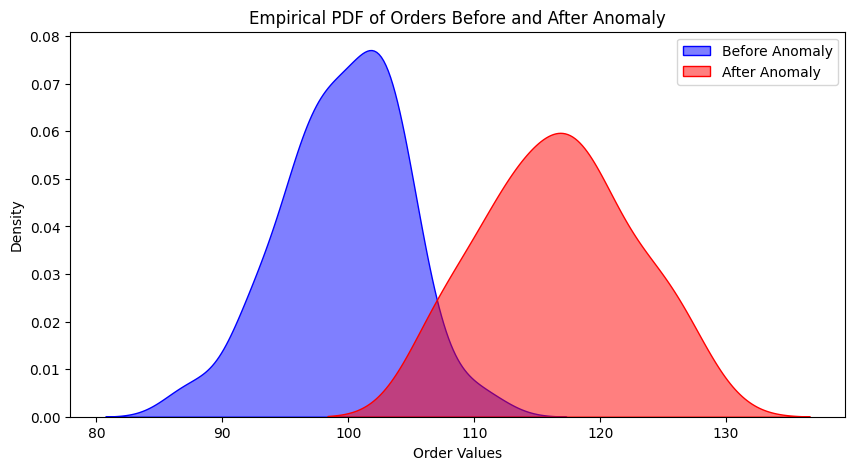

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
before_anomaly = df_rb.loc[df_rb['time'] < time_switch]['amount_per_month']
after_anomaly = df_rb.loc[df_rb['time'] > time_switch]['amount_per_month']

sns.kdeplot(before_anomaly, label='Before Anomaly', color='blue', fill=True, alpha=0.5)
sns.kdeplot(after_anomaly, label='After Anomaly', color='red', fill=True, alpha=0.5)

ax.set_xlabel('Order Values')
ax.set_ylabel('Density')
ax.set_title('Empirical PDF of Orders Before and After Anomaly')
ax.legend()

plt.show()

#### Discussion

On the plots above, we can detect a change in customer behavior on various levels of confidence based on the Z-score. 
* Does this remind you of p-values?
* How will change our detection uncertainty when we:
    1. decrease the mean value after sanction switch?
    2. change the size of the window?
* What regions in the plot of two empirical probability density distributions corresponds to errors? 

Think about **separability** of two signals (sets).